<a href="https://colab.research.google.com/github/MasihHosseinzadeh/MaskRCNN_PelletClassification/blob/main/Hosseinzadeh_MaskRCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Converting coco jason to masks


In [ ]:
!pip install pycocotools opencv-python

In [ ]:
import os
import cv2
import numpy as np
from pycocotools.coco import COCO

# Load COCO JSON file
coco = COCO('/content/sample_data/_annotations.coco.json')

# Get all image ids
img_ids = coco.getImgIds()
if not os.path.exists('masks'):
    os.makedirs('masks')

for img_id in img_ids:

    img_info = coco.loadImgs(img_id)[0]
    img_name = img_info['file_name']
    ann_ids = coco.getAnnIds(imgIds=img_id)
    anns = coco.loadAnns(ann_ids)
    for i, ann in enumerate(anns):
        # Get binary mask
        binary_mask = coco.annToMask(ann)

        # Save binary mask
        cv2.imwrite(f'masks/{img_name}_mask_{i}.png', binary_mask )


loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


In [ ]:
!zip -r /content/train_mask.zip /content/masks

  adding: content/masks/ (stored 0%)
  adding: content/masks/Slide168_JPG.rf.fa6e34590d3419d139086583eaebd844.jpg_mask_0.png (deflated 18%)
  adding: content/masks/Slide198_JPG.rf.48a72951ba184e9aaaedbd5c91fadbf4.jpg_mask_0.png (deflated 9%)
  adding: content/masks/Slide60_JPG.rf.649c289a40a91a87a5b65561c07fb6ed.jpg_mask_0.png (deflated 13%)
  adding: content/masks/Slide137_JPG.rf.6a3af26ec2d9487feb9aea21fcdd2acd.jpg_mask_0.png (deflated 9%)
  adding: content/masks/Slide170_JPG.rf.b78819d8f2f76972c41740ff4bd9fd8e.jpg_mask_0.png (deflated 15%)
  adding: content/masks/Slide145_JPG.rf.4e5e40637f644cf15051201a9340e85f.jpg_mask_0.png (deflated 19%)
  adding: content/masks/Slide136_JPG.rf.657540a812fc92e1e791ff6c812c3f85.jpg_mask_0.png (deflated 13%)
  adding: content/masks/Slide152_JPG.rf.79a50df825d66b4882c291604beec1c1.jpg_mask_0.png (deflated 13%)
  adding: content/masks/Slide49_JPG.rf.99189aa5f18271063a2603db81612b5e.jpg_mask_0.png (deflated 18%)
  adding: content/masks/Slide229_JPG.rf.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision import transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

In [ ]:
!unrar x "/content/sample_data/train_data.rar" "/content/sample_data/train_data"
!unrar x "/content/sample_data/train_mask.rar" "/content/sample_data/train_mask"


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/sample_data/train_data.rar

Creating    /content/sample_data/train_data/train_data                OK
Extracting  /content/sample_data/train_data/train_data/Slide100_JPG.rf.1387edbc3ba61516595b4f191e0a01b9.jpg       0%  OK 
Extracting  /content/sample_data/train_data/train_data/Slide100_JPG.rf.8f6bc16198ba7195e395857ae339cccf.jpg       0%  OK 
Extracting  /content/sample_data/train_data/train_data/Slide100_JPG.rf.e3407dec03ebf93520f37f20e0dca529.jpg       0%  OK 
Extracting  /content/sample_data/train_data/train_data/Slide101_JPG.rf.5a79a61f8e19b780f51efe6b5c915193.jpg       0%  OK 
Extracting  /content/sample_data/train_data/train_data/Slide101_JPG.rf.aa10e93a5dea96fe442a5ad0bd9b4191.jpg       0%  OK 
Extracting  /content/sample_data/train_data/train_data/Slide101_JPG.rf.ee450bd2e0772ae0337a783166df4d22.jpg       0%  OK 
Extracting  

In [ ]:
images = sorted(os.listdir("/content/drive/MyDrive/train_data_pellet/train_data/Slide8_JPG.rf.182930c5735f73bba60d614e19fc808b.jpg"))
masks = sorted(os.listdir("/content/drive/MyDrive/train_mask_pellet/train_mask/content/masks/Slide8_JPG.rf.182930c5735f73bba60d614e19fc808b.jpg_mask_0.png"))

NotADirectoryError: [Errno 20] Not a directory: '/content/drive/MyDrive/train_data_pellet/train_data/Slide8_JPG.rf.182930c5735f73bba60d614e19fc808b.jpg'

In [ ]:

idx = 0
img = Image.open("/content/drive/MyDrive/train_data_pellet/train_data/Slide64_JPG.rf.f2784c8c4968c0004f0cce554533455f.jpg").convert("RGB")
mask = Image.open("/content/drive/MyDrive/train_mask_pellet/train_mask/content/masks/Slide64_JPG.rf.f2784c8c4968c0004f0cce554533455f.jpg_mask_0.png")

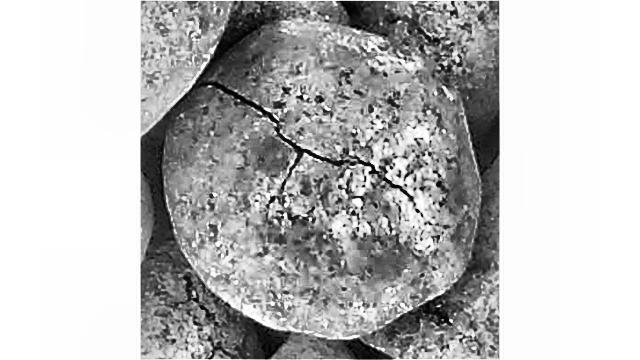

In [ ]:
img

In [ ]:
np.unique(mask)

array([0, 1], dtype=uint8)

In [ ]:
Mask= np.array(mask) == 1

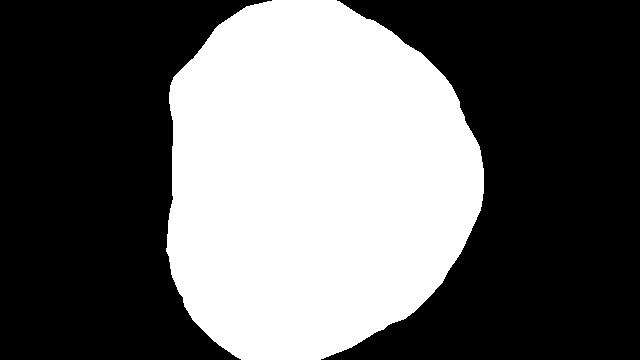

In [ ]:
Image.fromarray(np.array(mask) == 1)


In [ ]:
class CustDat(torch.utils.data.Dataset):
    def __init__(self , images , masks):
        self.imgs = images
        self.masks = masks

    def __getitem__(self , idx):
        img = Image.open("/content/drive/MyDrive/train_data_pellet/train_data/" + self.imgs[idx]).convert("RGB")
        mask = Image.open("/content/drive/MyDrive/train_mask_pellet/train_mask/content/masks/" + self.masks[idx])
        mask = np.array(mask)
        obj_ids = np.unique(mask)
        obj_ids = obj_ids[1:]
        num_objs = len(obj_ids)
        masks = np.zeros((num_objs , mask.shape[0] , mask.shape[1]))
        for i in range(num_objs):
            masks[i][mask == i+1] = True
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin , ymin , xmax , ymax])
        boxes = torch.as_tensor(boxes , dtype = torch.float32)
        labels = torch.ones((num_objs,) , dtype = torch.int64)
        masks = torch.as_tensor(masks , dtype = torch.uint8)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        return T.ToTensor()(img) , target

    def __len__(self):
        return len(self.imgs)

In [ ]:
model = torchvision.models.detection.maskrcnn_resnet50_fpn()
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features , 2)
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask , hidden_layer , 2)

In [ ]:
transform = T.ToTensor()


In [ ]:
def custom_collate(data):
  return data


In [ ]:
images = sorted(os.listdir("/content/drive/MyDrive/train_data_pellet/train_data"))
masks = sorted(os.listdir("/content/drive/MyDrive/train_mask_pellet/train_mask/content/masks"))
num = int(0.7 * len(images))
num = num if num % 2 == 0 else num + 1
train_imgs_inds = np.random.choice(range(len(images)) , num , replace = False)
val_imgs_inds = np.setdiff1d(range(len(images)) , train_imgs_inds)
train_imgs = np.array(images)[train_imgs_inds]
val_imgs = np.array(images)[val_imgs_inds]
train_masks = np.array(masks)[train_imgs_inds]
val_masks = np.array(masks)[val_imgs_inds]

In [ ]:
val_imgs

array(['Slide100_JPG.rf.e3407dec03ebf93520f37f20e0dca529.jpg',
       'Slide101_JPG.rf.5a79a61f8e19b780f51efe6b5c915193.jpg',
       'Slide102_JPG.rf.53a361f401e001b21158b90fe2d35aef.jpg',
       'Slide102_JPG.rf.b22a038f7f32a1969fb4ae79e9f5de24.jpg',
       'Slide102_JPG.rf.fdb8a6ebd6b1fb06cf0fe79578b87f7f.jpg',
       'Slide103_JPG.rf.ff59d050c44c906c01187f67cb46353f.jpg',
       'Slide110_JPG.rf.eb89852002b38aac35456bbdc1adf5e4.jpg',
       'Slide111_JPG.rf.986998760f1e9fac9a6a007463164462.jpg',
       'Slide113_JPG.rf.5e2fe777b2dc054bc92eb83d4c4b8796.jpg',
       'Slide116_JPG.rf.4a0b405b51f8e489eb15b45dad107e86.jpg',
       'Slide116_JPG.rf.58f0d28616a65f88e08b43ff7b6eaf43.jpg',
       'Slide117_JPG.rf.03978b9b311de563cfe07a85bc061673.jpg',
       'Slide117_JPG.rf.5f5bf17a8f1e8a4d5b39543bf77fdef1.jpg',
       'Slide117_JPG.rf.c0eda177e121c33b47ab6abc4a643584.jpg',
       'Slide120_JPG.rf.e4a17fb9516219b319237ca24b5bfcf4.jpg',
       'Slide123_JPG.rf.a65eacf7a57f2869c253ae2fed7b6f2

In [ ]:
train_dl = torch.utils.data.DataLoader(CustDat(train_imgs , train_masks) ,
                                 batch_size = 2 ,
                                 shuffle = True ,
                                 collate_fn = custom_collate ,
                                 num_workers = 1 ,
                                 pin_memory = True if torch.cuda.is_available() else False)
val_dl = torch.utils.data.DataLoader(CustDat(val_imgs , val_masks) ,
                                 batch_size = 2 ,
                                 shuffle = True ,
                                 collate_fn = custom_collate ,
                                 num_workers = 1 ,
                                 pin_memory = True if torch.cuda.is_available() else False)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
print(len(train_dl))
print(len(val_dl))

231
99


In [ ]:
model.to(device)


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu):

In [ ]:
params = [p for p in model.parameters() if p.requires_grad]


In [ ]:
optimizer = torch.optim.SGD(params, lr=0.0005, momentum=0.9, weight_decay=0.0005)


In [ ]:
val_dl

In [ ]:
all_train_losses = []
all_val_losses = []
flag = False
for epoch in range(150):
    train_epoch_loss = 0
    val_epoch_loss = 0
    model.train()
    for i , dt in enumerate(train_dl):
        print(len(dt))
        print(dt[0][0].shape, dt[1][0].shape)
        if len(dt) > 1:
            imgs = [dt[0][0].to(device) , dt[1][0].to(device)]
            targ = [dt[0][1] , dt[1][1]]
        else:
            imgs = [dt[0][0].to(device)]
            targ = [dt[0][1]]


        targets = [{k: v.to(device) for k, v in t.items()} for t in targ]
        loss = model(imgs , targets)
        if not flag:
            print(loss)
            flag = True
        losses = sum([l for l in loss.values()])
        train_epoch_loss += losses.cpu().detach().numpy()
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
    all_train_losses.append(train_epoch_loss)
    with torch.no_grad():
        for j , dt in enumerate(val_dl):
            #print(len(dt))
            #print(dt[0][0].shape, dt[1][0].shape)

            if len(dt) > 1:
                imgs = [dt[0][0].to(device) , dt[1][0].to(device)]
                targ = [dt[0][1] , dt[1][1]]
            else:
                imgs = [dt[0][0].to(device)]
                targ = [dt[0][1]]


            targets = [{k: v.to(device) for k, v in t.items()} for t in targ]
            loss = model(imgs , targets)
            losses = sum([l for l in loss.values()])
            val_epoch_loss += losses.cpu().detach().numpy()
        all_val_losses.append(val_epoch_loss)
    print(epoch , "  " , train_epoch_loss , "  " , val_epoch_loss)

2
torch.Size([3, 360, 640]) torch.Size([3, 360, 640])
{'loss_classifier': tensor(0.0865, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0204, grad_fn=<DivBackward0>), 'loss_mask': tensor(0.2295, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_objectness': tensor(0.5649, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0128, grad_fn=<DivBackward0>)}
2
torch.Size([3, 360, 640]) torch.Size([3, 360, 640])
2
torch.Size([3, 360, 640]) torch.Size([3, 360, 640])
2
torch.Size([3, 360, 640]) torch.Size([3, 360, 640])
2
torch.Size([3, 360, 640]) torch.Size([3, 360, 640])
2
torch.Size([3, 360, 640]) torch.Size([3, 360, 640])
2
torch.Size([3, 360, 640]) torch.Size([3, 360, 640])
2
torch.Size([3, 360, 640]) torch.Size([3, 360, 640])
2
torch.Size([3, 360, 640]) torch.Size([3, 360, 640])
2
torch.Size([3, 360, 640]) torch.Size([3, 360, 640])
2
torch.Size([3, 360, 640]) torch.Size([3, 360, 640])
2
torch.Size([3, 360, 640]) torch.Size([3, 360, 640])
2
torch.Si

Text(0, 0.5, 'Binary Cross entropy Loss')

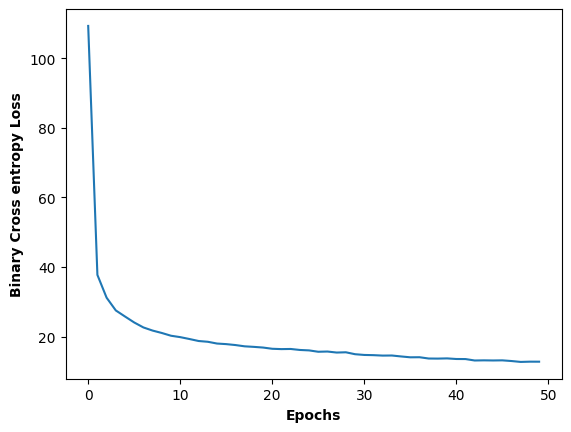

In [ ]:
plt.plot(all_train_losses)
plt.rcParams["font.serif"] = "Times New Roman"


plt.xlabel("Epochs", weight='bold')
plt.ylabel("Binary Cross entropy Loss", weight='bold')


Text(0, 0.5, 'Binary Cross entropy Loss')

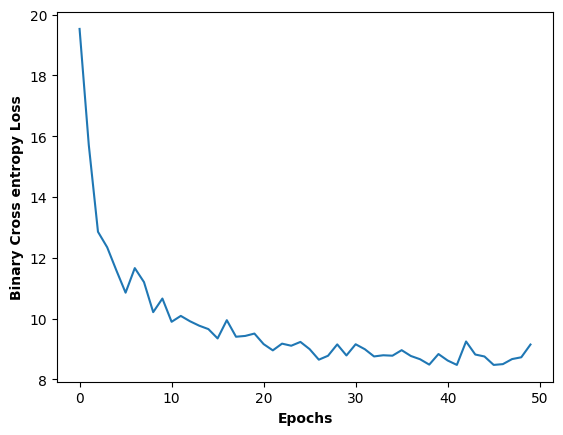

In [ ]:
plt.plot(all_val_losses)
#plt.rcParams["font.serif"] = "Times New Roman"
# Assuming the loss decreases linearly

plt.figure(figsize=(10, 6))



plt.xlabel("Epochs",fontname='Times New Roman', fontsize=14, weight='bold')
plt.ylabel("Binary Cross entropy Loss",fontname='Times New Roman', fontsize=14, weight='bold')

In [ ]:
model.eval()
img = Image.open("/content/drive/MyDrive/train_data_pellet/train_data/Slide100_JPG.rf.1387edbc3ba61516595b4f191e0a01b9.jpg")
transform = T.ToTensor()
ig = transform(img)
with torch.no_grad():
    pred = model([ig.to(device)])

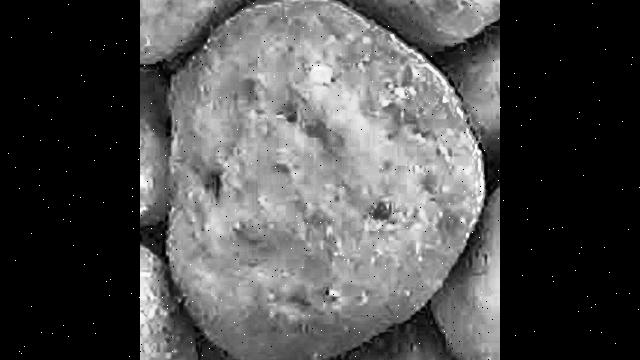

In [ ]:
img

In [ ]:
pred

[{'boxes': tensor([[160.6117,   0.0000, 488.4343, 356.6900]], device='cuda:0'),
  'labels': tensor([1], device='cuda:0'),
  'scores': tensor([1.0000], device='cuda:0'),
  'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]]], device='cuda:0')}]

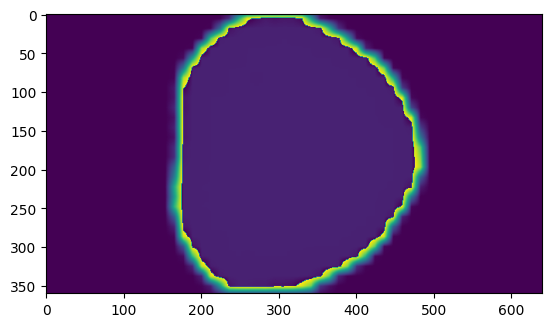

In [ ]:
plt.imshow((pred[0]["masks"][0].cpu().detach().numpy() * 280).astype("uint8").squeeze())


In [ ]:
img = Image.open("/content/drive/MyDrive/train_data_pellet/train_data/Slide100_JPG.rf.1387edbc3ba61516595b4f191e0a01b9.jpg").convert("RGB")
mask = Image.open("/content/drive/MyDrive/train_mask_pellet/train_mask/content/masks/Slide100_JPG.rf.1387edbc3ba61516595b4f191e0a01b9.jpg_mask_0.png")

In [ ]:
np.array(mask) == 1


False

In [ ]:
Image.fromarray(np.array(mask) == 1)

In [ ]:
import torch
import torchvision.transforms as T
from torchvision.models.detection import maskrcnn_resnet50_fpn
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

image = Image.open("/content/sample_data/New_Dataset/New_Dataset_MaskRCNN/Train/Image/1.jpg")
# Transform the image
transform = T.Compose([T.ToTensor()])
image_tensor = transform(image)

# Add a batch dimension
image_tensor = image_tensor.unsqueeze(0)

# Perform inference
with torch.no_grad():
    prediction = model(image_tensor)

# Get the first predicted mask and resize it to the image size
mask = prediction[0]['masks'][0, 0]
mask = mask.mul(255).byte().cpu().numpy()
mask = Image.fromarray(mask)
mask = mask.resize(image.size)

# Create a subplot
fig, ax = plt.subplots(1, 2)

# Display the original image and the mask
ax[0].imshow(image)
ax[0].set_title('Original Image')

ax[1].imshow(mask, cmap='gray')
ax[1].set_title('Predicted Mask')

plt.show()